In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors
from rdkit.Chem.EState import Fingerprinter
from rdkit.Chem import PandasTools
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
def get_fps(mol):
    # this calculates all RDKit descriptors (clogP, PSA, etc etc)
    calc=MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    ds = np.asarray(calc.CalcDescriptors(mol))
    
    # EState fingerprints
    arr=Fingerprinter.FingerprintMol(mol)[0]
    
    # Morgan fingerprints
    #fps=AllChem.GetMorganFingerprintAsBitVect(mol,3,nBits=1024)
    #arr=np.zeros((1,))
    #DataStructs.ConvertToNumpyArray(fps, arr)
    
    return np.append(arr,ds)

In [3]:
# load data from CSV. Keep only smiles, compound name and pIC50 columns
# the data set is here: https://github.com/deepchem/deepchem/blob/master/datasets/desc_canvas_aug30.csv
df=pd.read_csv('desc_canvas_aug30.csv',usecols=[0,1,4])

In [4]:
# randomly shuffle the data
df = shuffle(df)

In [5]:
df.head()

,mol,CID,pIC50
813,S1(=O)(=O)N(CCCC1)c1cc(cc(NCC)c1)C(=O)NC(Cc1ccccc1)C(O)C[NH2+]C1CC1,BACE_839,6.920819
691,O1CCCCNc2cc(cc(c2)C(=O)NC(Cc2cc1ccc2)C(O)C[NH2+]Cc1cc(ccc1)C(C)C)COC,BACE_717,7.221849
1310,O(C)c1ccc(cc1)C1(N=C(N)CC1)c1cc(ccc1)-c1cncnc1,BACE_1336,5.102373
1039,O1CCCCNc2cc(cc(c2)C(=O)NC(Cc2cc1ccc2)C(O)C[NH2+]C(COC)c1cc(ccc1)C(C)(C)C)COC,BACE_1065,6.175223
309,Fc1cc(cc(F)c1)CC(NC(=O)C(N1CCC(C(O)CCC)C1=O)CCc1ccccc1)C(O)C[NH2+]Cc1cc(OC)ccc1,BACE_335,8.283997


In [6]:
# add RDKit molecule column to the dataframe
PandasTools.AddMoleculeColumnToFrame(df,'mol','Molecule')

,mol,CID,pIC50,Molecule
813,S1(=O)(=O)N(CCCC1)c1cc(cc(NCC)c1)C(=O)NC(Cc1ccccc1)C(O)C[NH2+]C1CC1,BACE_839,6.920819,
691,O1CCCCNc2cc(cc(c2)C(=O)NC(Cc2cc1ccc2)C(O)C[NH2+]Cc1cc(ccc1)C(C)C)COC,BACE_717,7.221849,
1310,O(C)c1ccc(cc1)C1(N=C(N)CC1)c1cc(ccc1)-c1cncnc1,BACE_1336,5.102373,
1039,O1CCCCNc2cc(cc(c2)C(=O)NC(Cc2cc1ccc2)C(O)C[NH2+]C(COC)c1cc(ccc1)C(C)(C)C)COC,BACE_1065,6.175223,
309,Fc1cc(cc(F)c1)CC(NC(=O)C(N1CCC(C(O)CCC)C1=O)CCc1ccccc1)C(O)C[NH2+]Cc1cc(OC)ccc1,BACE_335,8.283997,

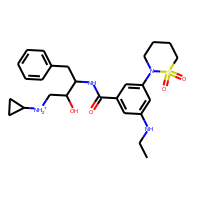
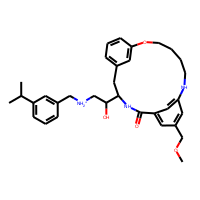
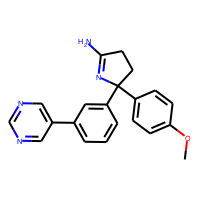
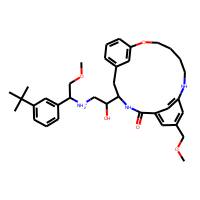
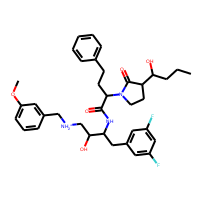

In [7]:
df.head()

In [8]:
# calculate molecular fingerprints and descriptors and add to the dataframe
df['Descriptors']=df['Molecule'].apply(get_fps)

In [9]:
# tag molecules with pIC50>6 as active (Active = 1)
df['Active']=np.where(df['pIC50']>6, 1, 0)

In [10]:
# convert to numpy arrays
X = np.array(list(df['Descriptors']))
y = df['Active'].values
 
# divide into train and test set
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [11]:
# create a random forest model and fit the data
rf = RandomForestClassifier(max_features='auto')
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [12]:
# make predictions on the test set
y_pred = rf.predict(X_test)

In [13]:
# get the ROC statistics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

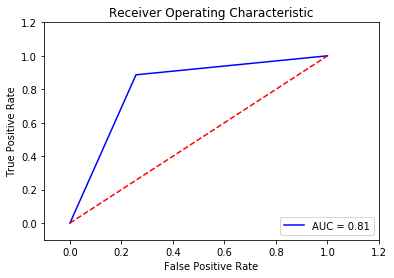

In [14]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()